In [1]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(rtracklayer)
    library(tidyverse)
    library(ggbeeswarm)
    library(purrr)
    library(parallel)
})

In [2]:
source("../code/process_slim_vcf.R")

In [3]:
regions <- c("merged", "exon", "promoter", "protein_coding", "tf_binding_site", "utr3", "neutral_Ne_10000")

In [4]:
region_sizes <- sapply(regions, function(reg) {
    r <- ifelse(str_detect(reg, "neutral"), "tf_binding_site", reg)
    gr <- import.bed(paste0("../data/bed/regions/", r, "_regions.bed"))
    sum(width(gr))
})
region_sizes["neutral_Ne_10000"] <- 0

In [5]:
centromeres <- get_centromeres()

### Single pulse of admixture

In [6]:
desert_sizes <- lapply(1:5, function(rep_i) {

map(regions, function(region) {
    vcf <- readVcf(paste0("../data/simulations/deserts_", region, "_h_0.5_rep_", rep_i, "_gen_2200.vcf.gz"))
    r <- ifelse(str_detect(region, "neutral"), "tf_binding_site", region)
    markers <- get_markers(vcf, paste0("../data/slim_coords/", r, "_all_sites.bed"), within_region="gap")

    deserts <- get_deserts(markers, cutoff=0.001)
    if (is.null(deserts)) return(NULL)
    desert_hits <- queryHits(findOverlaps(deserts, centromeres))
    nogap_deserts <- if (length(desert_hits)) deserts[-desert_hits] else deserts

    tibble(region=region,
           size=width(nogap_deserts) / 1e6)
}) %>% bind_rows %>% mutate(rep=rep_i)

}) %>% bind_rows %>%
    mutate(region=factor(region, levels=names(region_sizes)[order(region_sizes, decreasing=TRUE)]))

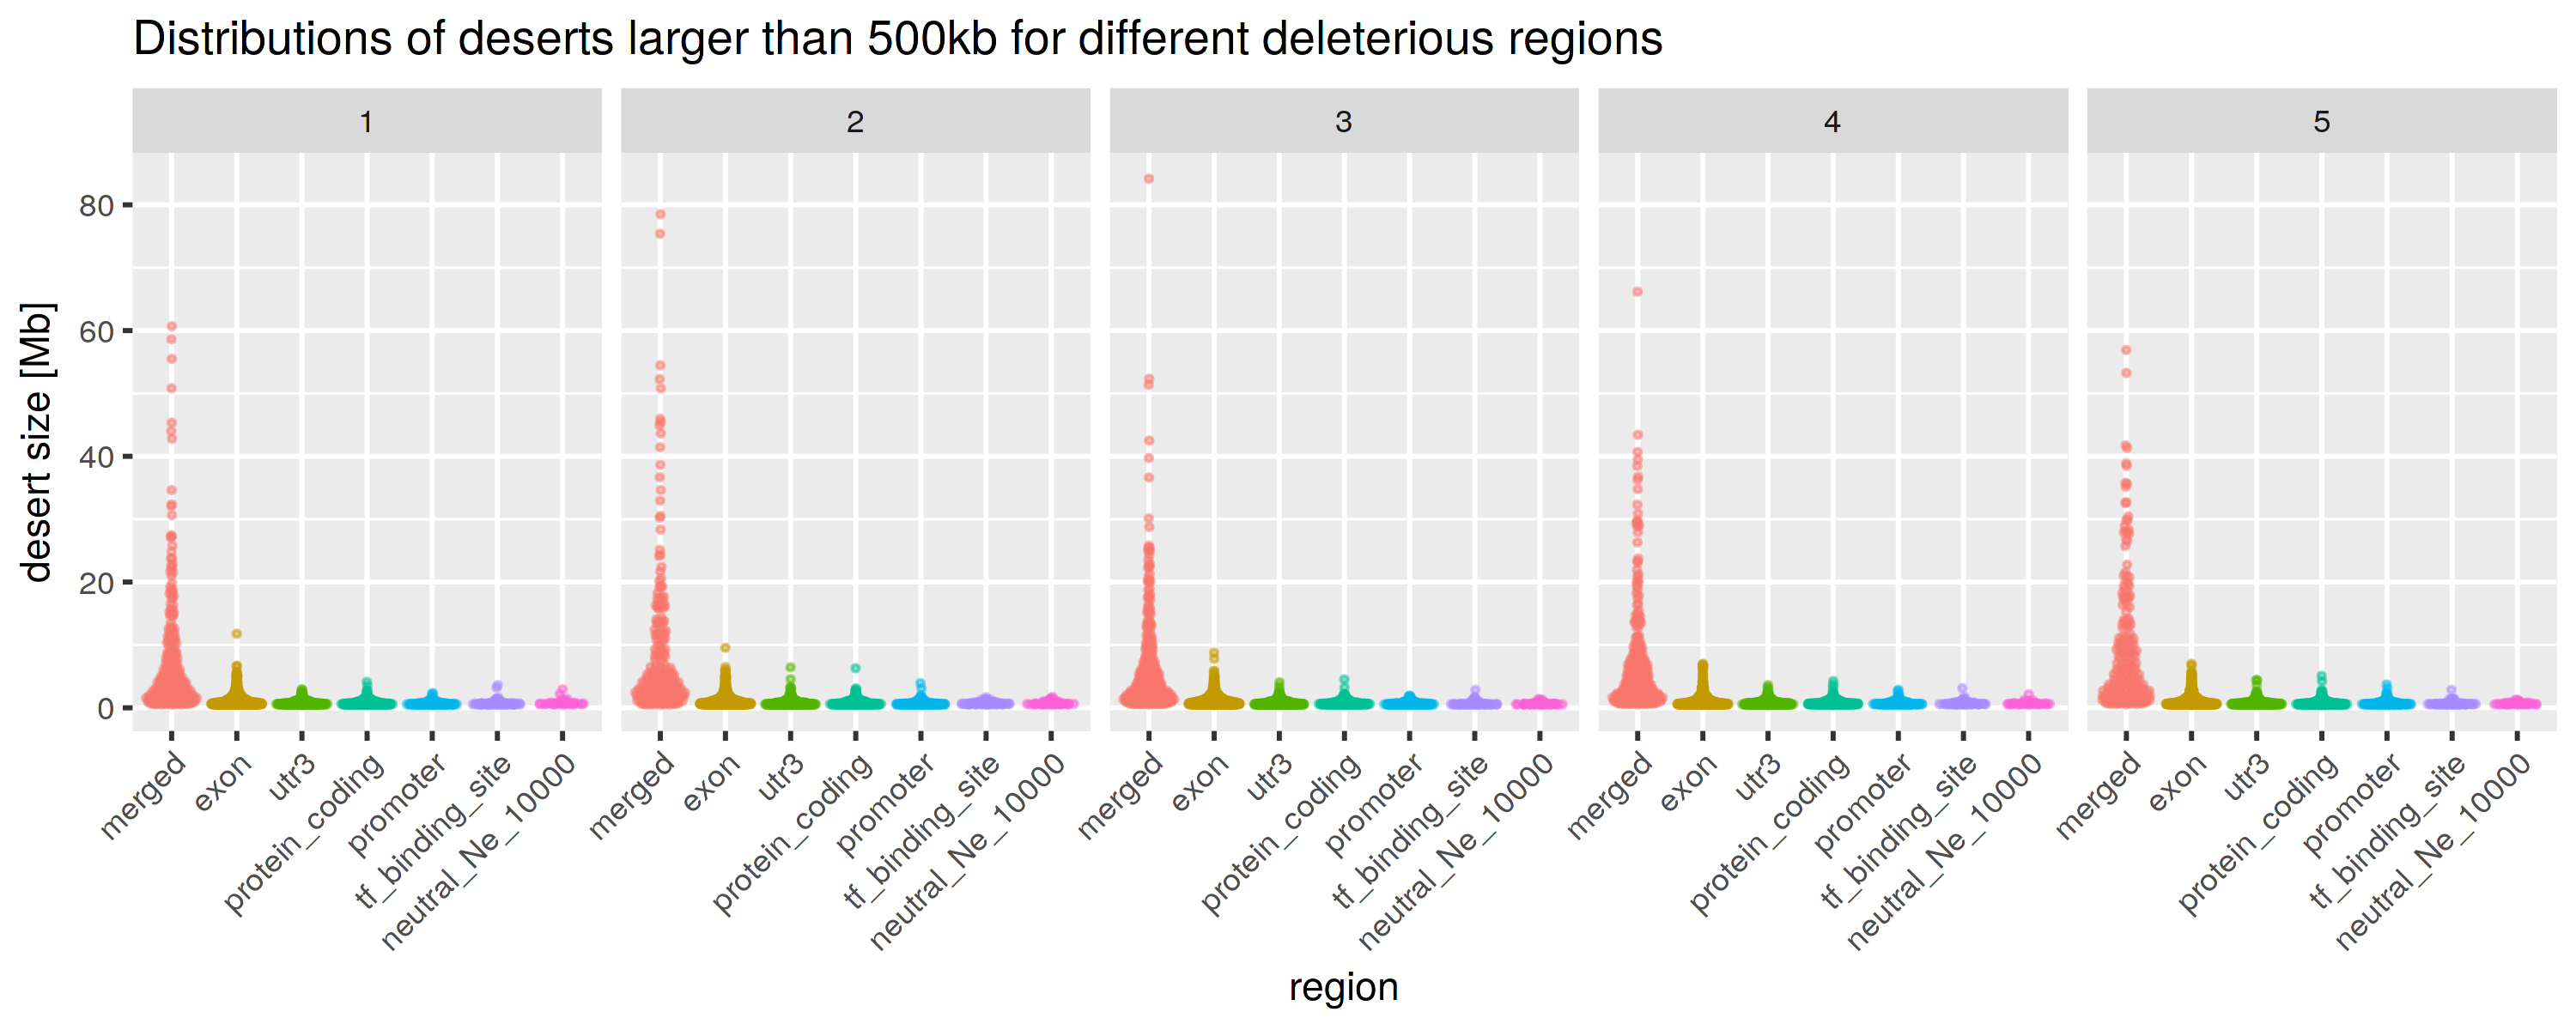

In [7]:
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

group_by(desert_sizes, region, rep) %>% filter(size > 0.5) %>%
ggplot(aes(region, size, color=region)) + geom_quasirandom(alpha=1/2, size=0.5) +
ggtitle("Distributions of deserts larger than 500kb for different deleterious regions") +
ylab("desert size [Mb]") +
facet_grid(. ~ rep) +
theme(legend.position="botom", axis.text.x=element_text(hjust=1, angle=45))

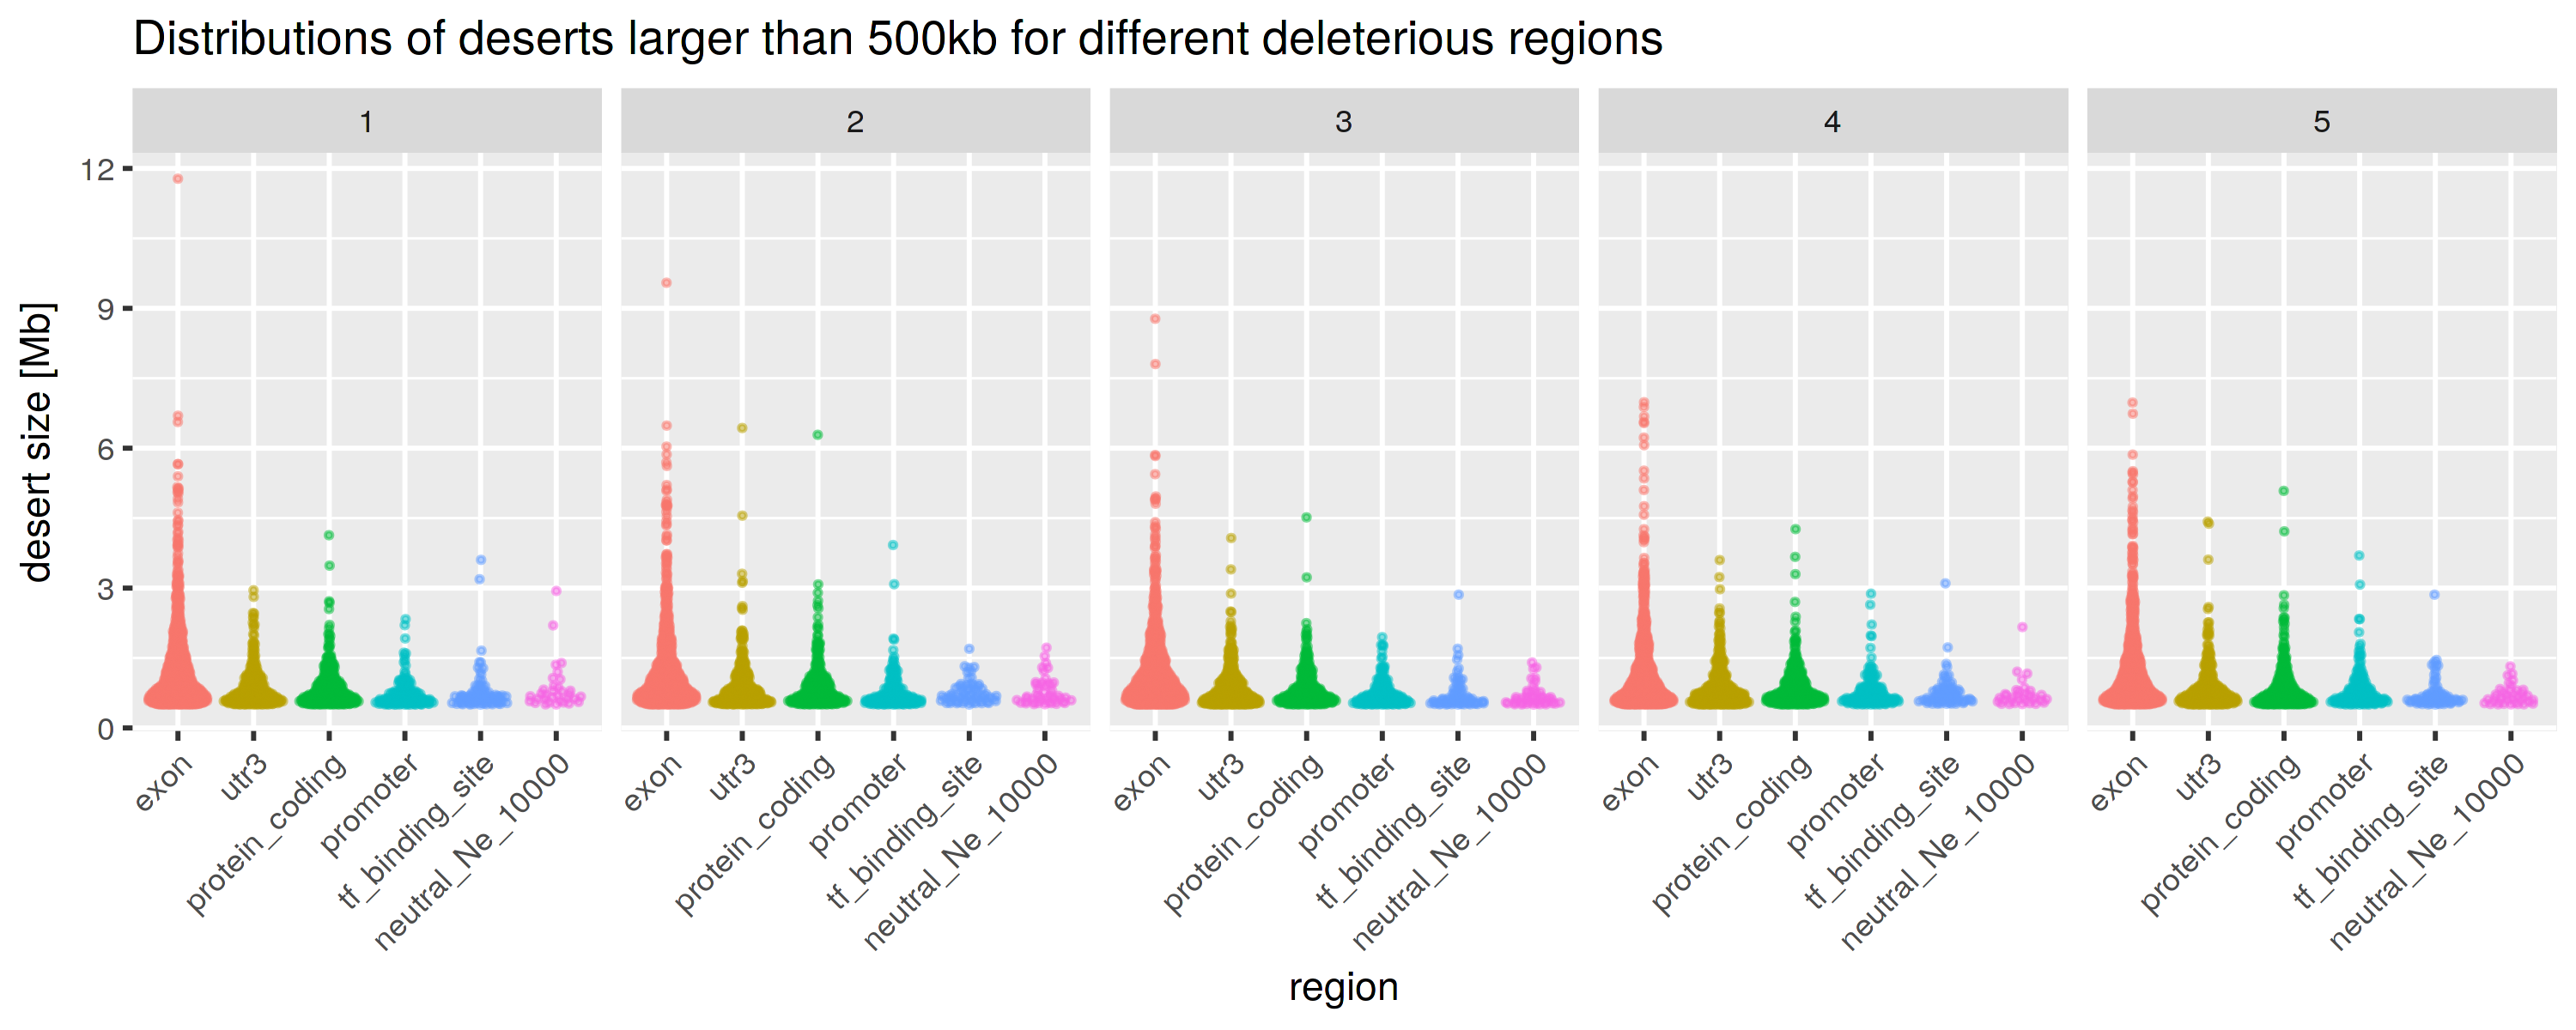

In [8]:
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

group_by(desert_sizes, region, rep) %>% filter(size > 0.5, region != "merged") %>%
ggplot(aes(region, size, color=region)) + geom_quasirandom(alpha=1/2, size=0.5) +
ggtitle("Distributions of deserts larger than 500kb for different deleterious regions") +
ylab("desert size [Mb]") +
facet_grid(. ~ rep) +
theme(legend.position="botom", axis.text.x=element_text(hjust=1, angle=45))

### Desert size summary stats for all regions

In [9]:
group_by(desert_sizes, region) %>% summarise(mean(size),
                                             median(size),
                                             min(size),
                                             max(size))

region,mean(size),median(size),min(size),max(size)
merged,5.48107642,1.8124160,1e-06,84.157685
exon,0.39527312,0.1436715,1e-06,11.780012
utr3,0.14238814,0.0354415,1e-06,6.433101
protein_coding,0.13425826,0.0305540,1e-06,6.286775
promoter,0.08579937,0.0086410,1e-06,3.923337
tf_binding_site,0.06310946,0.0000370,1e-06,3.605356
neutral_Ne_10000,0.04895859,0.0000010,1e-06,2.938404


### 1000 years of continuous admixture

In [10]:
cont_desert_sizes <- lapply(1:3, function(rep_i) {

map(setdiff(regions, "merged"), function(region) {
    vcf <- readVcf(paste0("../data/simulations/continuous_deserts_", region, "_h_0.5_rep_", rep_i, "_gen_2200.vcf.gz"))
    r <- ifelse(str_detect(region, "neutral"), "tf_binding_site", region)
    markers <- get_markers(vcf, paste0("../data/slim_coords/", r, "_all_sites.bed"), within_region="gap")

    deserts <- get_deserts(markers, cutoff=0.001)
    if (is.null(deserts)) return(NULL)
    desert_hits <- queryHits(findOverlaps(deserts, centromeres))
    nogap_deserts <- if (length(desert_hits)) deserts[-desert_hits] else deserts

    tibble(region=region,
           size=width(nogap_deserts) / 1e6)
}) %>% bind_rows %>% mutate(rep=rep_i)

}) %>% bind_rows %>%
    mutate(region=factor(region, levels=names(region_sizes)[order(region_sizes, decreasing=TRUE)]))

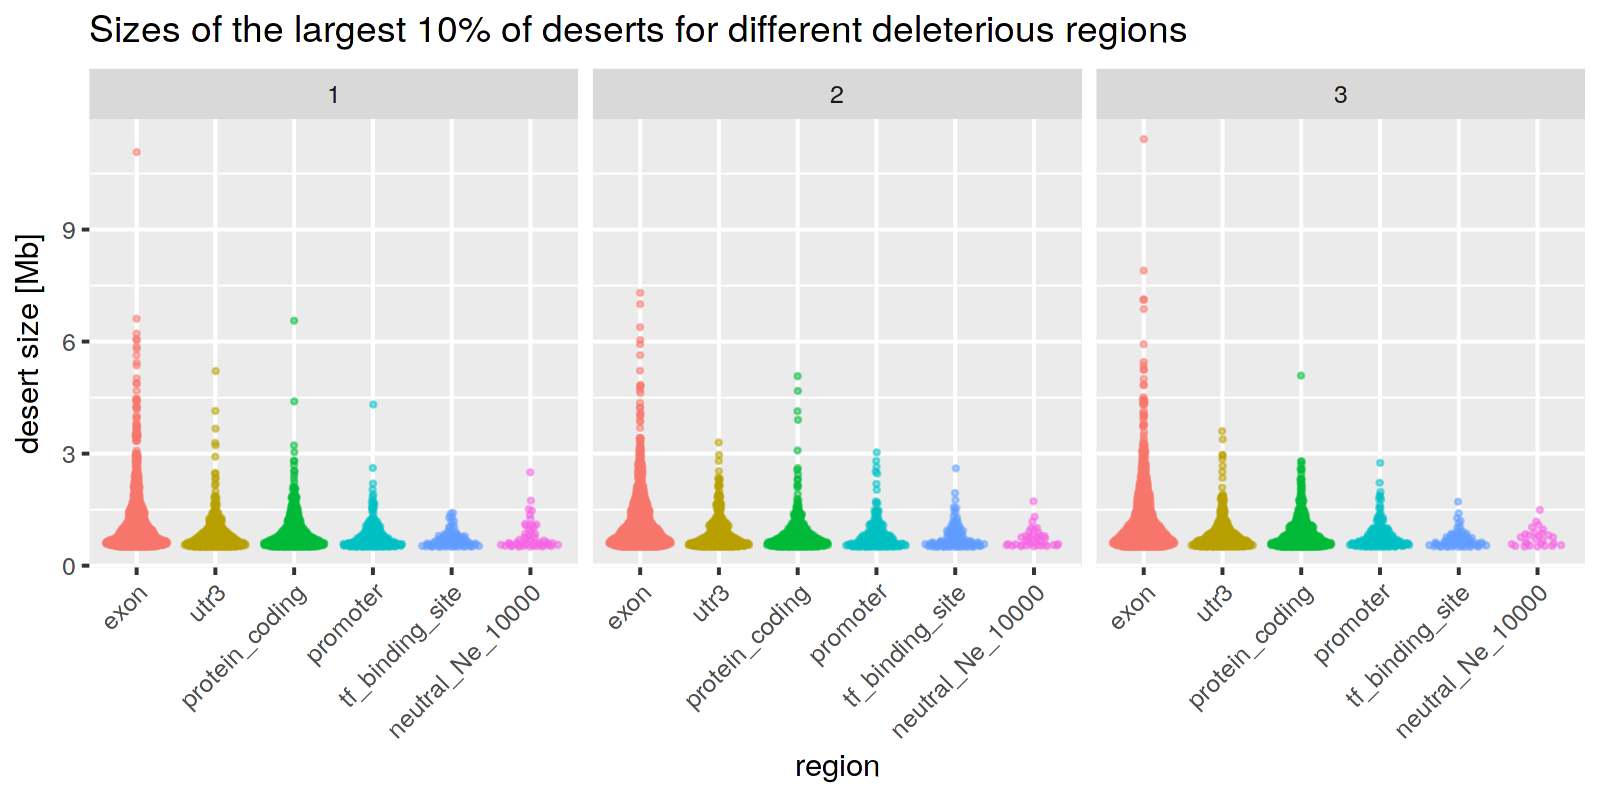

In [11]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=200)

group_by(cont_desert_sizes, region, rep) %>% filter(size > 0.5) %>%
ggplot(aes(region, size, color=region)) + geom_quasirandom(alpha=1/2, size=0.5) +
ggtitle("Sizes of the largest 10% of deserts for different deleterious regions") +
ylab("desert size [Mb]") +
facet_wrap(~ rep) +
theme(legend.position="botom", axis.text.x=element_text(hjust=1, angle=45))

### Desert size summary stats for all regions

In [12]:
group_by(desert_sizes, region) %>% summarise(mean(size),
                                             median(size),
                                             min(size),
                                             max(size))

region,mean(size),median(size),min(size),max(size)
merged,5.48107642,1.8124160,1e-06,84.157685
exon,0.39527312,0.1436715,1e-06,11.780012
utr3,0.14238814,0.0354415,1e-06,6.433101
protein_coding,0.13425826,0.0305540,1e-06,6.286775
promoter,0.08579937,0.0086410,1e-06,3.923337
tf_binding_site,0.06310946,0.0000370,1e-06,3.605356
neutral_Ne_10000,0.04895859,0.0000010,1e-06,2.938404


# Deserts over time

In [13]:
centromeres <- get_centromeres()

In [14]:
# AF changes over time
gens <- c(seq(1, 10), 20, 50, 100, seq(200, 2200, 200))

# region simulated
reg <- "exon"

In [15]:
time_desert_sizes <- lapply(1:3, function(rep_i) {
    
mclapply(mc.cores=length(gens), gens, function(gen) {
    vcf <- readVcf(paste0("../data/simulations/", reg, "_h_0.5_rep_", rep_i, "_gen_", gen, ".vcf.gz"))
    markers <- get_markers(vcf, paste0("../data/slim_coords/", reg, "_all_sites.bed"), within_region="gap")

    deserts <- get_deserts(markers, cutoff=0.001)
    if (is.null(deserts)) return(NULL)

    desert_hits <- queryHits(findOverlaps(deserts, centromeres))
    nogap_deserts <- if (length(desert_hits)) deserts[-desert_hits] else deserts

    tibble(gen=gen, size=width(nogap_deserts) / 1e6, rep=rep_i)
}) %>% bind_rows
    
}) %>% bind_rows

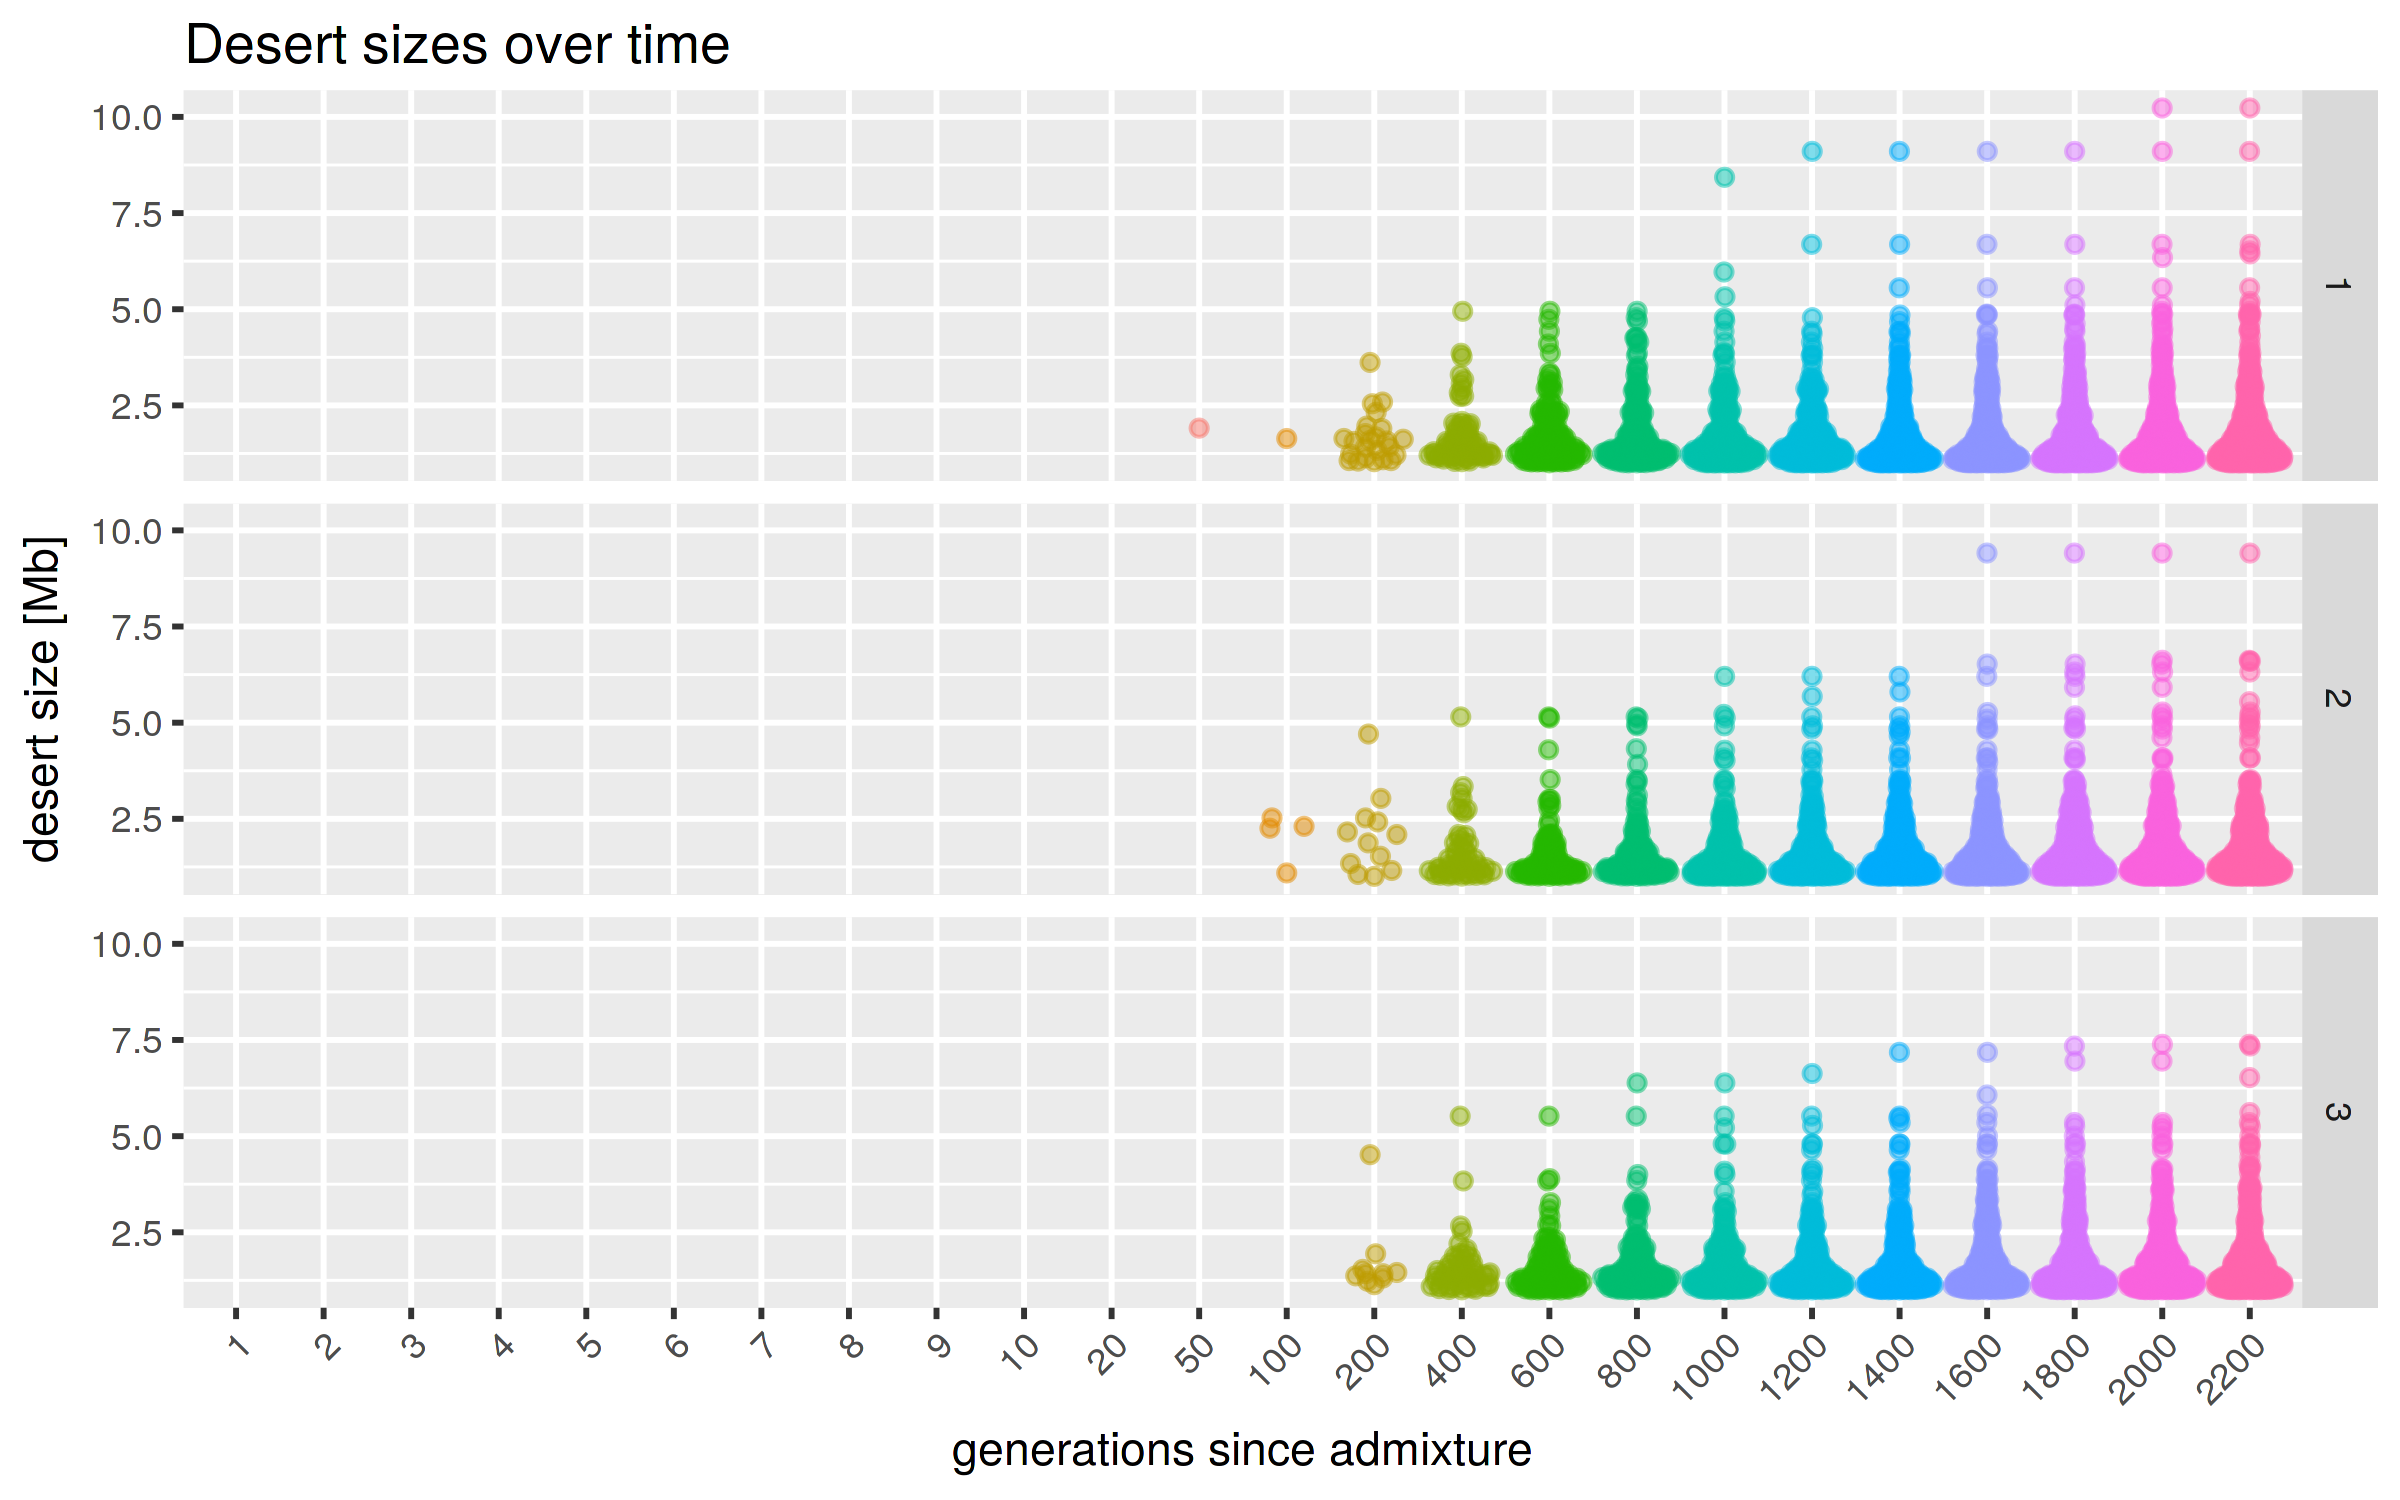

In [16]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=300)

time_desert_sizes %>% mutate(gen=factor(gen, levels=gens)) %>% 
filter(size > 1) %>% 
ggplot(aes(gen, size, fill=gen, group=gen, color=gen)) + geom_quasirandom(alpha=1/2) +
ggtitle("Desert sizes over time") +
facet_grid(rep ~ .) +
xlab("generations since admixture") + ylab("desert size [Mb]") +
theme(legend.position="none", axis.text.x=element_text(hjust=1, angle=45)) +
scale_x_discrete(drop=FALSE)

## Overlap of deserts

Let's take the 10 biggest deserts from each exon replicate and look at their overlap.

In [17]:
library(ggbio)

Need specific help about ggbio? try mailing 
 the maintainer or visit http://tengfei.github.com/ggbio/

Attaching package: 'ggbio'

The following objects are masked from 'package:ggplot2':

    geom_bar, geom_rect, geom_segment, ggsave, stat_bin, stat_identity,
    xlim



In [18]:
library(BSgenome.Hsapiens.UCSC.hg19)

Loading required package: BSgenome


In [19]:
region <- "exon"

large_deserts <- lapply(1:5, function(rep_i) {
    vcf <- readVcf(paste0("../data/simulations/deserts_", region, "_h_0.5_rep_", rep_i, "_gen_2200.vcf.gz"))
    r <- ifelse(str_detect(region, "neutral"), "tf_binding_site", region)
    markers <- get_markers(vcf, paste0("../data/slim_coords/", r, "_all_sites.bed"), within_region="gap")

    deserts <- get_deserts(markers, cutoff=0.001)
    if (is.null(deserts)) return(NULL)
    desert_hits <- queryHits(findOverlaps(deserts, centromeres))
    nogap_deserts <- if (length(desert_hits)) deserts[-desert_hits] else deserts

#    largest <- nogap_deserts[order(width(nogap_deserts), decreasing=TRUE)][1:5]
    largest <- nogap_deserts[width(nogap_deserts) > 5e6]
    largest$rep <- rep_i
    
    seqinfo(largest) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
    seqlevels(largest, pruning.mode="coarse") <- paste0("chr", 1:22)

    largest
})

In [20]:
hg19 <- GRanges(seqinfo(BSgenome.Hsapiens.UCSC.hg19))
seqlevels(hg19, pruning.mode="coarse") <- paste0("chr", 1:22)

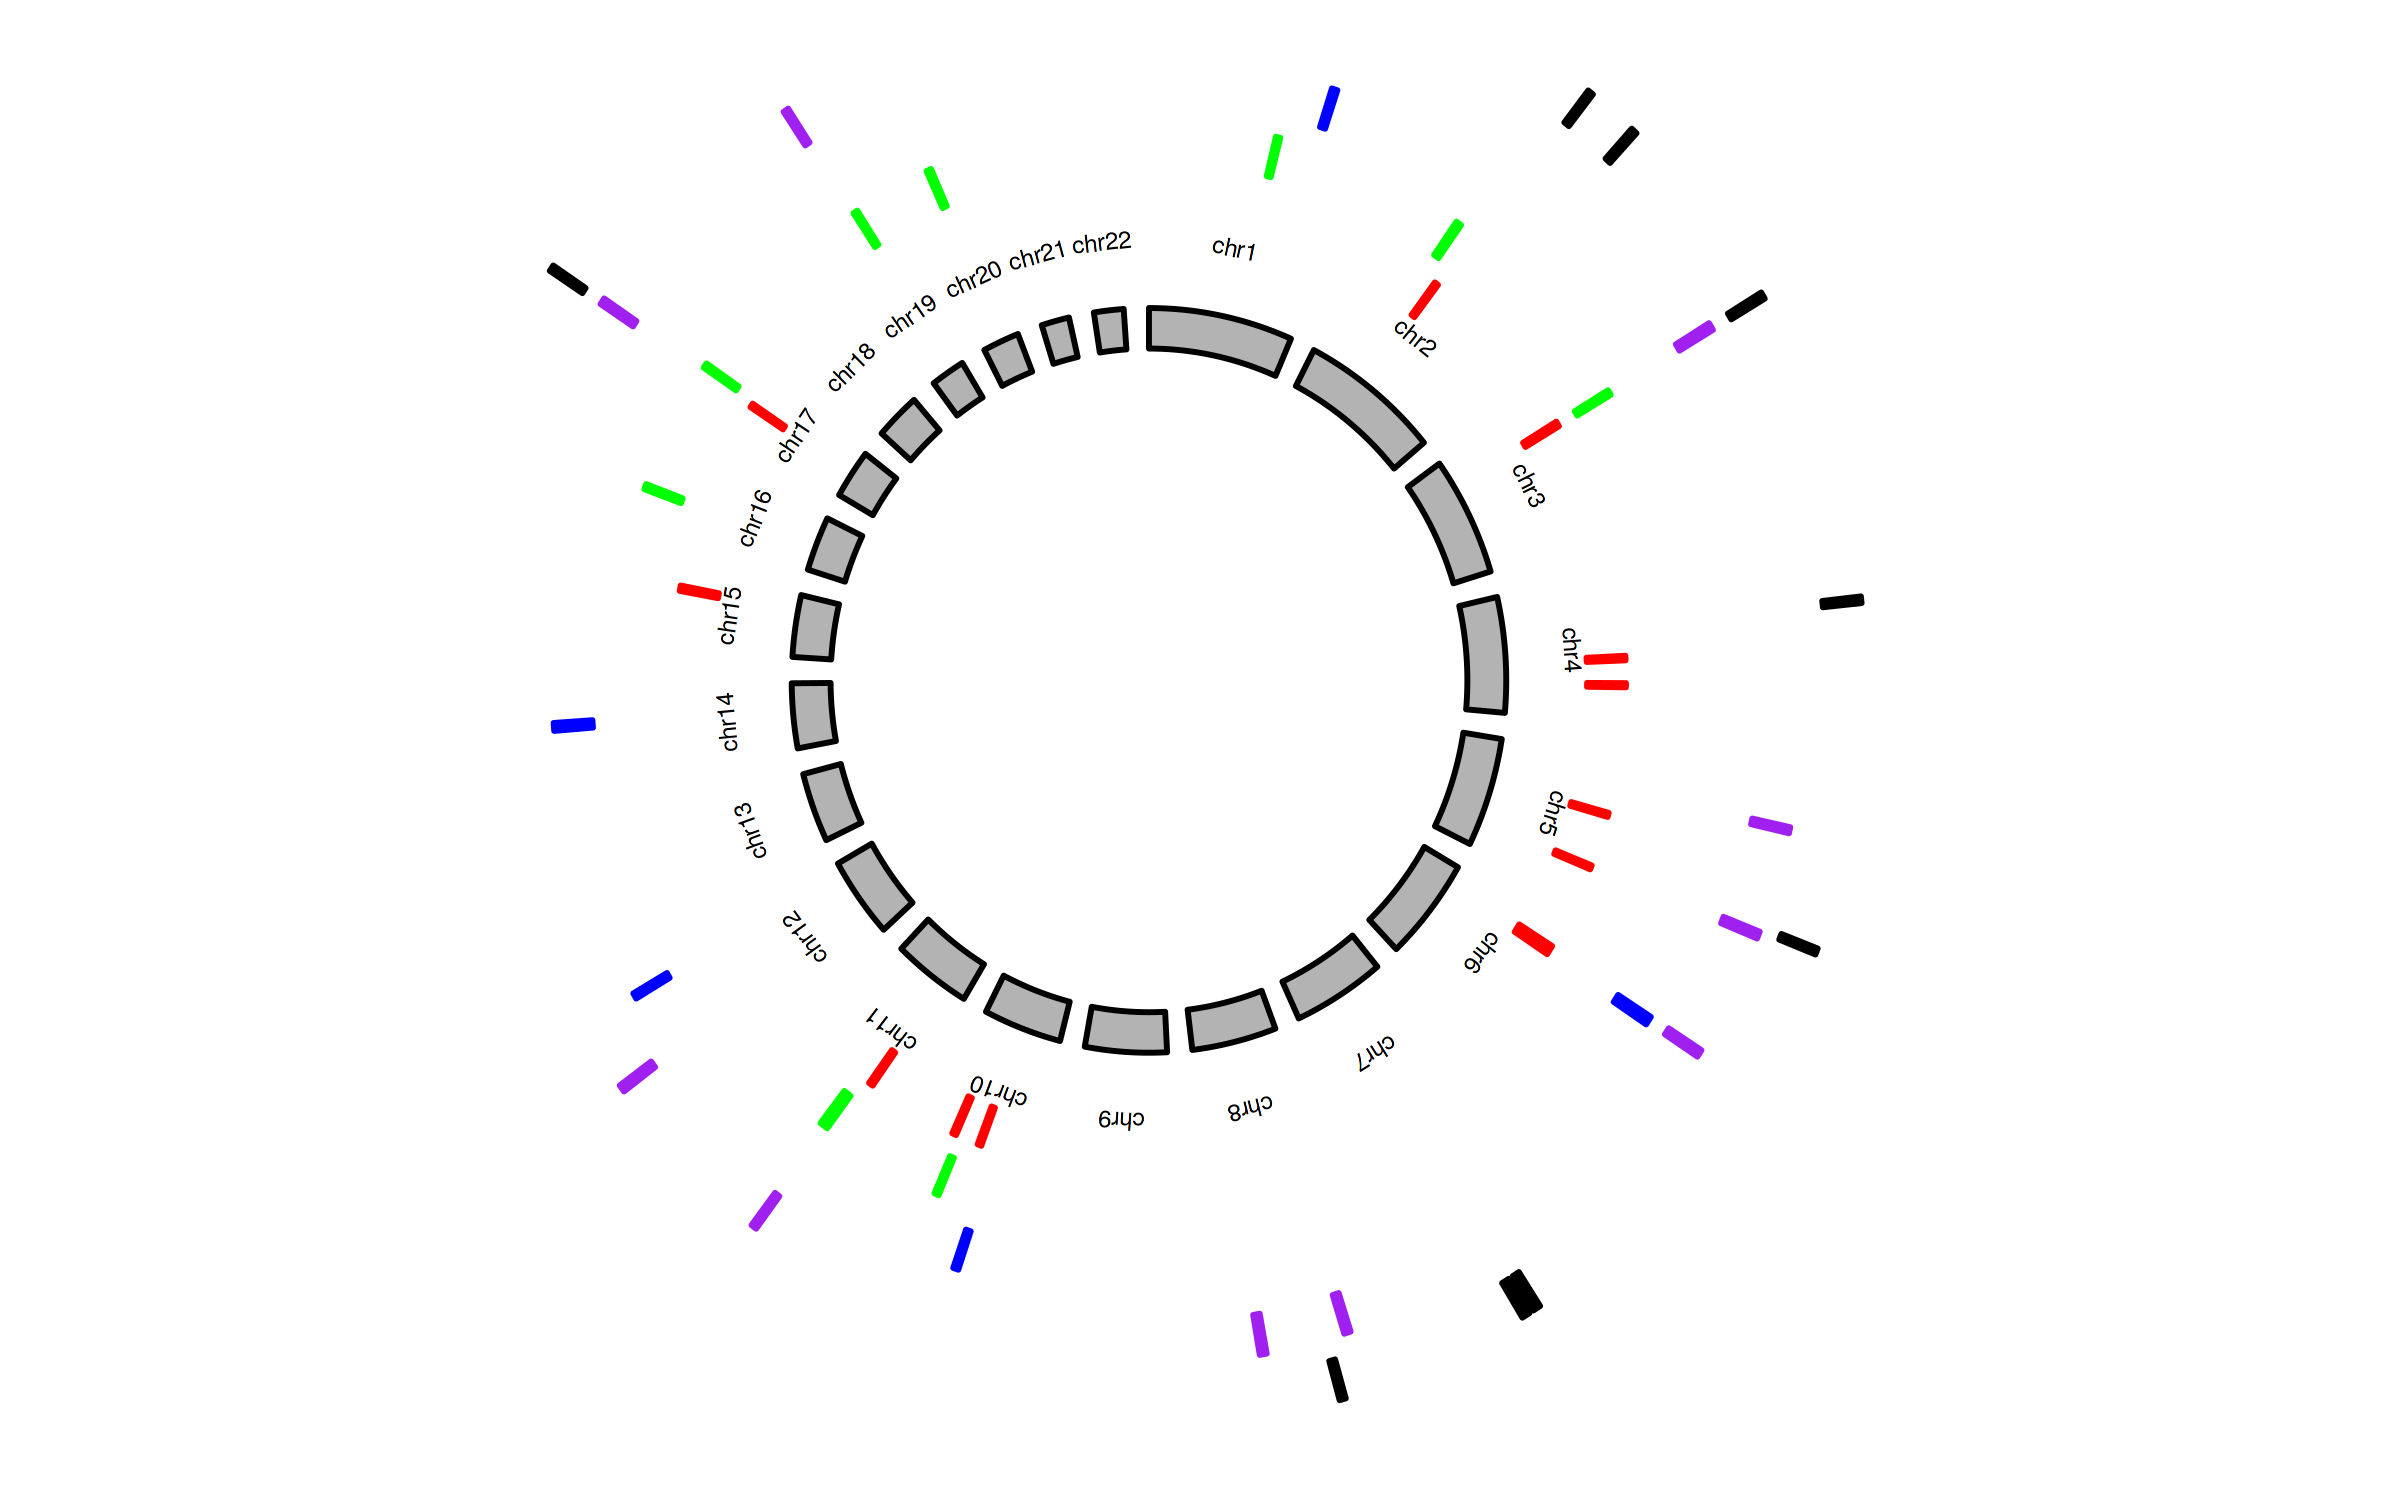

In [21]:
ggbio() + circle(hg19, geom = "ideo", fill = "gray70") +
    circle(hg19, geom = "text", aes(label = seqnames), vjust = -1, size = 2) +
    circle(large_deserts[[1]], geom = "rect", fill="red", color="red") +
    circle(large_deserts[[2]], geom = "rect", fill="green", color="green") +
    circle(large_deserts[[3]], geom = "rect", fill="blue", color="blue") +
    circle(large_deserts[[4]], geom = "rect", fill="purple", color="purple") +
    circle(large_deserts[[5]], geom = "rect", fill="black", color="black")

Run this from multiple burnins:

In [22]:
save.image("../data/RData/slim_deserts.RData")